# Hypotesis Testing 

Desarrollar y probar herramientas para hacer hypotesis testing con Python.


### References

- [MLMastery: 17 Statistical Hypothesis Tests in Python (Cheat Sheet)](https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/)
- [How to Use Statistical Significance Tests to Interpret Machine Learning Results](https://machinelearningmastery.com/use-statistical-significance-tests-interpret-machine-learning-results/)
- [p-values problemas fail for too large samles](https://www.semanticscholar.org/paper/Research-Commentary-Too-Big-to-Fail%3A-Large-Samples-Lin-Lucas/7241c748932deb734fff1681e951e50be0853a39?p2df)

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
from scipy.stats import kurtosis
from scipy.stats import skew

## load data

In [2]:
# load dataset
dataset = load_iris()
dataset.keys()
# dataset to df
data = pd.DataFrame(dataset.data, columns = dataset.feature_names)
data['class'] = dataset.target
dclass = dict()
for i, ic in enumerate(dataset.target_names):
    dclass[i] = ic
data['class'] = data['class'].map(dclass)

## df format

In [3]:
# check what columns are NUMERICAL or CATEGORICAL
cols_num = data.select_dtypes(include=['float64', 'int64']).columns.values  # numerical columns
cols_cat = data.select_dtypes(include=['object']).columns.values            # categorical columns
# columns name converters: numerical
dcols_num_name_to_alias = dict()
dcols_num_alias_to_name = dict()
for i, ic in enumerate(cols_num):
    dcols_num_name_to_alias[ic] = 'n{}'.format(i)
    dcols_num_alias_to_name['n{}'.format(i)] = ic
# columns name converters: categorical
dcols_cat_name_to_alias = dict()
dcols_cat_alias_to_name = dict()
for i, ic in enumerate(cols_cat):
    dcols_cat_name_to_alias[ic] = 'c{}'.format(i)
    dcols_cat_alias_to_name['c{}'.format(i)] = ic
# rename columns
data.rename(columns = dcols_num_name_to_alias, inplace = True)
data.rename(columns = dcols_cat_name_to_alias, inplace = True)
# list of alias
cols_num_alias = list(dcols_num_name_to_alias.values())
cols_cat_alias = list(dcols_cat_name_to_alias.values())

# descriptive analysis

### numerical

In [4]:
# describe
dfn = data[cols_num_alias].describe(include = 'all', percentiles = [.05, .25, .5, .75, .95]).T
# add percent of nan values
dfn['%nan'] = (data[cols_num_alias].isnull().sum()*100 / len(data)).values
# kurtosis
dfn['kurtosis'] = kurtosis(data[cols_num_alias])
# skew
dfn['skew'] = skew(data[cols_num_alias])
# rename index
dfn.index = dfn.index.map(dcols_num_alias_to_name)
dfn

,count,mean,std,min,5%,25%,50%,75%,95%,max,%nan,kurtosis,skew
sepal length (cm),150.0,5.843333,0.828066,4.3,4.600,5.1,5.80,6.4,7.255,7.9,0.0,-0.573568,0.311753
sepal width (cm),150.0,3.057333,0.435866,2.0,2.345,2.8,3.00,3.3,3.800,4.4,0.0,0.180976,0.315767
petal length (cm),150.0,3.758000,1.765298,1.0,1.300,1.6,4.35,5.1,6.100,6.9,0.0,-1.395536,-0.272128
petal width (cm),150.0,1.199333,0.762238,0.1,0.200,0.3,1.30,1.8,2.300,2.5,0.0,-1.336067,-0.101934


### categorical

In [5]:
# describe
dfc = data[cols_cat_alias].describe(include = 'all').T[['count', 'unique']]
# add percent of nan values
dfc['%nan'] = (data[cols_cat_alias].isnull().sum()*100 / len(data)).values

In [6]:
## add categories percenets

# maximum number of categories to be showed
max_size_cats = 5
# set columns
col_temp = ['var'] + ['value{}'.format(i) for i in range(max_size_cats)] + ['%value{}'.format(i) for i in range(max_size_cats)]
# initialize
values_temp = list()
# loop of variables
for col in cols_cat_alias:
    # count categories
    temp = data[col].value_counts(normalize=True,sort=True,ascending=False)*100.
    # collect values and names
    c = temp.index.values
    v = temp.values
    # resize
    if len(v) > max_size_cats:
        v = np.append(v[:max_size_cats-1], np.sum(v[-(max_size_cats):]))
        c = np.append(c[:max_size_cats-1], 'others')
    else:
        v = np.pad(v,(0, max_size_cats-len(v)), 'constant', constant_values=np.nan)
        c = np.pad(c,(0, max_size_cats-len(c)), 'constant', constant_values=np.nan)
    # append    
    values_temp.append([col] + list(np.append(c,v)))
# add new information
dfc = pd.concat([dfc, pd.DataFrame(values_temp, columns = col_temp).set_index('var')], axis = 1)
# rename index
dfc.index = dfc.index.map(dcols_cat_alias_to_name)
dfc

,count,unique,%nan,value0,value1,value2,value3,value4,%value0,%value1,%value2,%value3,%value4
var,,,,,,,,,,,,,
class,150,3,0.0,virginica,setosa,versicolor,NaN,NaN,33.333333,33.333333,33.333333,NaN,NaN


# TEST DE NORMALIDAD

## hapiro-Wilk Test / D’Agostino’s K^2 Test / nderson-Darling Test 

Tests whether a data sample has a Gaussian distribution.

### Assumptions

- Observations in each sample are independent and identically distributed (iid).

### Interpretation

- H0: the sample has a Gaussian distribution.
- H1: the sample does not have a Gaussian distribution.


In [8]:
def test_shapiro(data):
    from scipy.stats import shapiro
    stat, p = shapiro(data)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')

In [10]:
def test_k2(data):
    from scipy.stats import normaltest
    stat, p = normaltest(data)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably Gaussian')
    else:
        print('Probably not Gaussian')

In [12]:
def test_anderson(data):
    from scipy.stats import anderson
    result = anderson(data)
    print('stat=%.3f' % (result.statistic))
    for i in range(len(result.critical_values)):
        sl, cv = result.significance_level[i], result.critical_values[i]
        if result.statistic < cv:
            print('Probably Gaussian at the %.1f%% level' % (sl))
        else:
            print('Probably not Gaussian at the %.1f%% level' % (sl))

## prueba 1: caso de si normalidad

In [7]:
mu = 0; sigma = .1
v = np.random.normal(mu, sigma, 1000)

In [9]:
test_shapiro(v)

stat=0.999, p=0.803
Probably Gaussian


In [11]:
test_k2(v)

stat=0.079, p=0.961
Probably Gaussian


In [13]:
test_anderson(v)

stat=0.220
Probably Gaussian at the 15.0% level
Probably Gaussian at the 10.0% level
Probably Gaussian at the 5.0% level
Probably Gaussian at the 2.5% level
Probably Gaussian at the 1.0% level


## prueba 2: caso de no normalidad

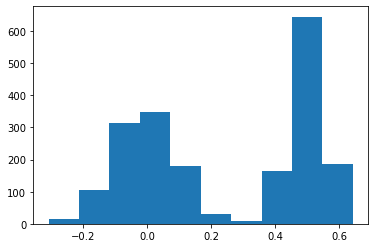

In [31]:
mu1 = 0; sigma1 = .1
mu2 = 0.5; sigma2 = .05
v = np.array(list(np.random.normal(mu1, sigma1, 1000)) + list(np.random.normal(mu2, sigma2, 1000)))
# plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.hist(v)
plt.show()

In [32]:
test_shapiro(v)

stat=0.853, p=0.000
Probably not Gaussian


In [33]:
test_k2(v)

stat=6.784, p=0.034
Probably not Gaussian


In [34]:
test_anderson(v)

stat=130.568
Probably not Gaussian at the 15.0% level
Probably not Gaussian at the 10.0% level
Probably not Gaussian at the 5.0% level
Probably not Gaussian at the 2.5% level
Probably not Gaussian at the 1.0% level


# TESTEAR variable numerica es RANDOM UNIFORM 

Basado en **Kolmogorov-Smirnov (2 samples)** para ver si la variable tiene una distribucion igual a una distribucion uniforme artificial.

In [189]:
def test_ks2(data1, data2):
    from scipy.stats import ks_2samp
    stat, p = ks_2samp(data1, data2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')
        
def test_uniform_num(data):
    from scipy.stats import uniform, ks_2samp
    dismin=np.amin(data)
    dismax=np.amax(data)
    T=uniform(dismin,dismax-dismin).rvs(data.shape[0])
    stat, p = ks_2samp(data, T)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably is Uniform')
    else:
        print('Probably is not Uniform') 

### prueba 1: si es uniforme

In [368]:
v = np.array([np.random.uniform() for i in range(1000)])

In [369]:
test_uniform_num(v)

stat=0.053, p=0.117
Probably is Uniform


### prueba 2: no es uniforme

In [370]:
mu = 0; sigma = .1
v = np.random.normal(mu, sigma, 1000)

In [371]:
test_uniform_num(v)

stat=0.260, p=0.000
Probably is not Uniform


# TESTEAR variable categorica es RANDOM UNIFORM 

He usado un **Kolmogorov-Smirnov (2 samples)** entre el sample y su correspondiente uniforme despues de transformar las categorias en valores numericos.

> NOTA: Introduje una validacion para samples demasiado grandes, pues en estos casos se vuelve demasiado fino. de esta manera le doy algo de margen para considerar que no es Uniforme.

In [652]:
def test_uniform_cat(data):
    from scipy.stats import ks_2samp
    # number of categories
    cats = np.unique(data)
    # resize if data is too large
    if len(data)>1000 and len(cats)*1000 < len(data):
        data = np.random.choice(data, size = len(cats)*1000)    
    # create artificial data with uniform distribution
    data_uniform = np.random.choice(cats, size = len(data), p = np.ones(len(cats)) / len(cats))
    # cat to num of input data
    temp = list()
    for ii, ic in enumerate(cats):
        temp += list(np.ones(len(data[data==ic])) * ii)
    data_modif = np.array(temp)
    # cat to num of artificial data
    temp = list()
    for ii, ic in enumerate(cats):
        temp += list(np.ones(len(data_uniform[data_uniform==ic])) * ii)
    data_uniform_modif = np.array(temp)
    # test
    stat, p = ks_2samp(data, data_uniform)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably is Uniform')
    else:
        print('Probably is not Uniform')     

### prueba 1: si es uniforme

In [657]:
v = np.random.choice(np.array(['1', '2', '3']), size = 10000, p = [0.33, 0.33, 0.34])
test_uniform_cat(v)

stat=0.018, p=0.712
Probably is Uniform


### prueba 2: no es uniforme

In [654]:
v = np.random.choice(np.array(['1', '2', '3']), size = 100000, p = [0.25, 0.5, 0.25])
test_uniform_cat(v)

stat=0.094, p=0.000
Probably is not Uniform


# MONOTONIC RELATIONSHIP (non-parametric tests)

Tests whether two samples have a monotonic relationship.

## Spearman's / Kendall's Rank Correlation Test

### Assumptions

- Observations in each sample are independent and identically distributed (iid).
- Observations in each sample can be ranked.

### Interpretation

- H0: the two samples are independent.
- H1: there is a dependency between the samples.

In [12]:
# columns selection
x1_col = cols_num_alias[2]
x2_col = cols_num_alias[3]
# collect data
df = data[[x1_col, x2_col]]
data1 = df[x1_col].values
data2 = df[x2_col].values

In [13]:
# Example of the Spearman's Rank Correlation Test
from scipy.stats import spearmanr

stat, p = spearmanr(data1, data2)
print('stat=%.3f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.938, p=0.00000
Probably dependent


In [15]:
# Example of the Kendall's Rank Correlation Test
from scipy.stats import kendalltau
stat, p = kendalltau(data1, data2)
print('stat=%.3f, p=%.5f' % (stat, p))
if p > 0.05:
    print('Probably independent')
else:
    print('Probably dependent')

stat=0.807, p=0.00000
Probably dependent


<AxesSubplot:xlabel='n2', ylabel='n3'>

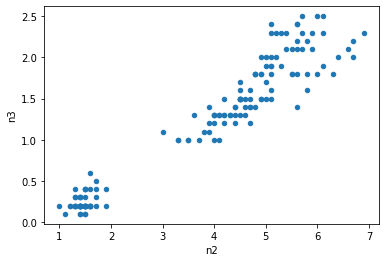

In [16]:
df.plot(kind = 'scatter', x = x1_col, y = x2_col)

# IDENTIFICACION DE HETEROGENEIDAD (non-parametric test for non-paired samples)

## Kruskal-Wallis H Test

Tests whether the distributions of **two or more** independent samples are equal or not.

### Assumptions

- Observations in each sample are independent and identically distributed (iid).
- Observations in each sample can be ranked.

### Interpretation

- H0: the distributions of all samples are equal.
- H1: the distributions of one or more samples are not equal.


In [44]:
def test_kruskal2(data1, data2):
    from scipy.stats import kruskal
    stat, p = kruskal(data1, data2)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')
        
def test_kruskal3(data1, data2, data3):
    from scipy.stats import kruskal
    stat, p = kruskal(data1, data2, data3)
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

### prueba 1: deberia identificarse heterogeneidad

In [40]:
col_num = dcols_num_name_to_alias['petal length (cm)']
col_cat = dcols_cat_name_to_alias['class']

v1 = data[data[col_cat] == 'setosa'][col_num].values
v2 = data[data[col_cat] == 'versicolor'][col_num].values
v3 = data[data[col_cat] == 'virginica'][col_num].values

In [41]:
test_kruskal2(v1, v2)

stat=74.699, p=0.000
Probably different distributions


In [42]:
test_kruskal2(v1, v3)

stat=74.694, p=0.000
Probably different distributions


In [43]:
test_kruskal2(v2, v3)

stat=69.206, p=0.000
Probably different distributions


In [45]:
test_kruskal3(v1, v2, v3)

stat=130.411, p=0.000
Probably different distributions


### prueba 2: no deberia identificarse heterogeneidad

In [50]:
mu = 0; sigma = .1
v = np.random.normal(mu, sigma, 1000)
v1 = v[:600]
v2 = v[600:]
v1.shape, v2.shape

((600,), (400,))

In [51]:
test_kruskal2(v1, v2)

stat=0.621, p=0.431
Probably the same distribution


# TEST IF SAME DISTRIBUTION (non-parametric test for paired samples)

## Wilcoxon Signed-Rank Test

Tests whether the distributions of two paired samples are equal or not.

### Assumptions

- Observations in each sample are independent and identically distributed (iid).
- Observations in each sample can be ranked.
- Observations across each sample are paired.

### Interpretation

- H0: the distributions of both samples are equal.
- H1: the distributions of both samples are not equal.


In [17]:
# Example of the Wilcoxon Signed-Rank Test
def test_wilcoxon(data1:np.array, data2:np.array):
    from scipy.stats import wilcoxon
    stat, p = wilcoxon(data1, data2)
    print('stat=%.5f, p=%.5f' % (stat, p))
    if p > 0.05:
        print('Probably the same distribution')
    else:
        print('Probably different distributions')

### prueba 1: 2 samples de una misma distribucion normal (homegeneidad)

In [28]:
mu = 0; sigma = .1
v1 = np.random.normal(mu, sigma, 100)
v2 = np.random.normal(mu, sigma, 100)

In [29]:
test_wilcoxon(v1, v2)

stat=2310.00000, p=0.45976
Probably the same distribution


### prueba 2: 2 samples de dos distribuciones normales muy parecidas pero no iguales (heterogeneidad)

In [30]:
mu1 = 0; sigma1 = .1
mu2 = 0.05; sigma2 = .1
v1 = np.random.normal(mu1, sigma1, 1000)
v2 = np.random.normal(mu2, sigma2, 1000)

In [31]:
test_wilcoxon(v1, v2)

stat=141390.00000, p=0.00000
Probably different distributions
